In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time
import sklearn

In [52]:
# Create a simple customer churn dataset
np.random.seed(42)
n_samples = 5000

# Generate synthetic customer data similar to wine quality data structure
data = pd.DataFrame({
    'tenure': np.random.randint(1, 72, n_samples),
    'monthly_charges': np.random.uniform(20, 120, n_samples).astype('float64'),
    'total_charges': np.random.uniform(100, 8000, n_samples).astype('float64'),
    'contract_length': np.random.choice([1, 12, 24], n_samples),
    'payment_method': np.random.choice([0, 1, 2, 3], n_samples),
    'paperless_billing': np.random.choice([0, 1], n_samples),
    'num_services': np.random.randint(1, 8, n_samples),
    'tech_support': np.random.choice([0, 1], n_samples),
    'online_security': np.random.choice([0, 1], n_samples),
    'device_protection': np.random.choice([0, 1], n_samples),
    'streaming_services': np.random.choice([0, 1], n_samples),
})

# Display first few rows
data.head()

,tenure,monthly_charges,total_charges,contract_length,payment_method,paperless_billing,num_services,tech_support,online_security,device_protection,streaming_services
0,52,119.408165,5752.946336,1,0,0,5,1,0,1,1
1,15,21.107855,5800.454556,24,3,0,6,0,0,0,1
2,61,93.017345,2330.937170,1,1,0,5,1,1,0,0
3,21,77.178932,6698.921041,24,3,0,1,1,0,0,1
4,24,63.405218,2603.075055,1,0,0,3,1,1,1,0


In [53]:
# Create churn target variable (similar to quality in wine dataset)
# Customers with short tenure and high charges are more likely to churn
churn_probability = (
    (data['tenure'] < 12) * 0.3 +
    (data['monthly_charges'] > 70) * 0.2 +
    (data['contract_length'] == 1) * 0.3 +
    (data['num_services'] < 3) * 0.2
)
data['churn'] = (churn_probability > 0.5).astype(int)

print(f"Dataset shape: {data.shape}")
print(f"Churn rate: {data['churn'].mean():.2%}")

Dataset shape: (5000, 12)
Churn rate: 10.38%


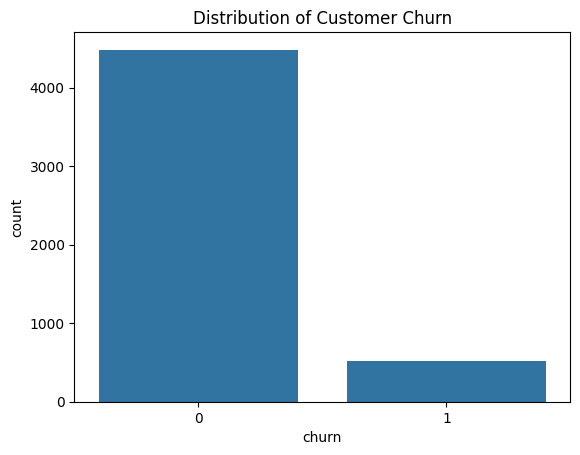

In [54]:
# Distribution of churn
sns.countplot(data=data, x='churn')
plt.title('Distribution of Customer Churn')
plt.show()

In [55]:
# Define high-risk customers (similar to high quality wine definition)
high_risk = (data.churn == 1).astype(int)
data.churn = high_risk

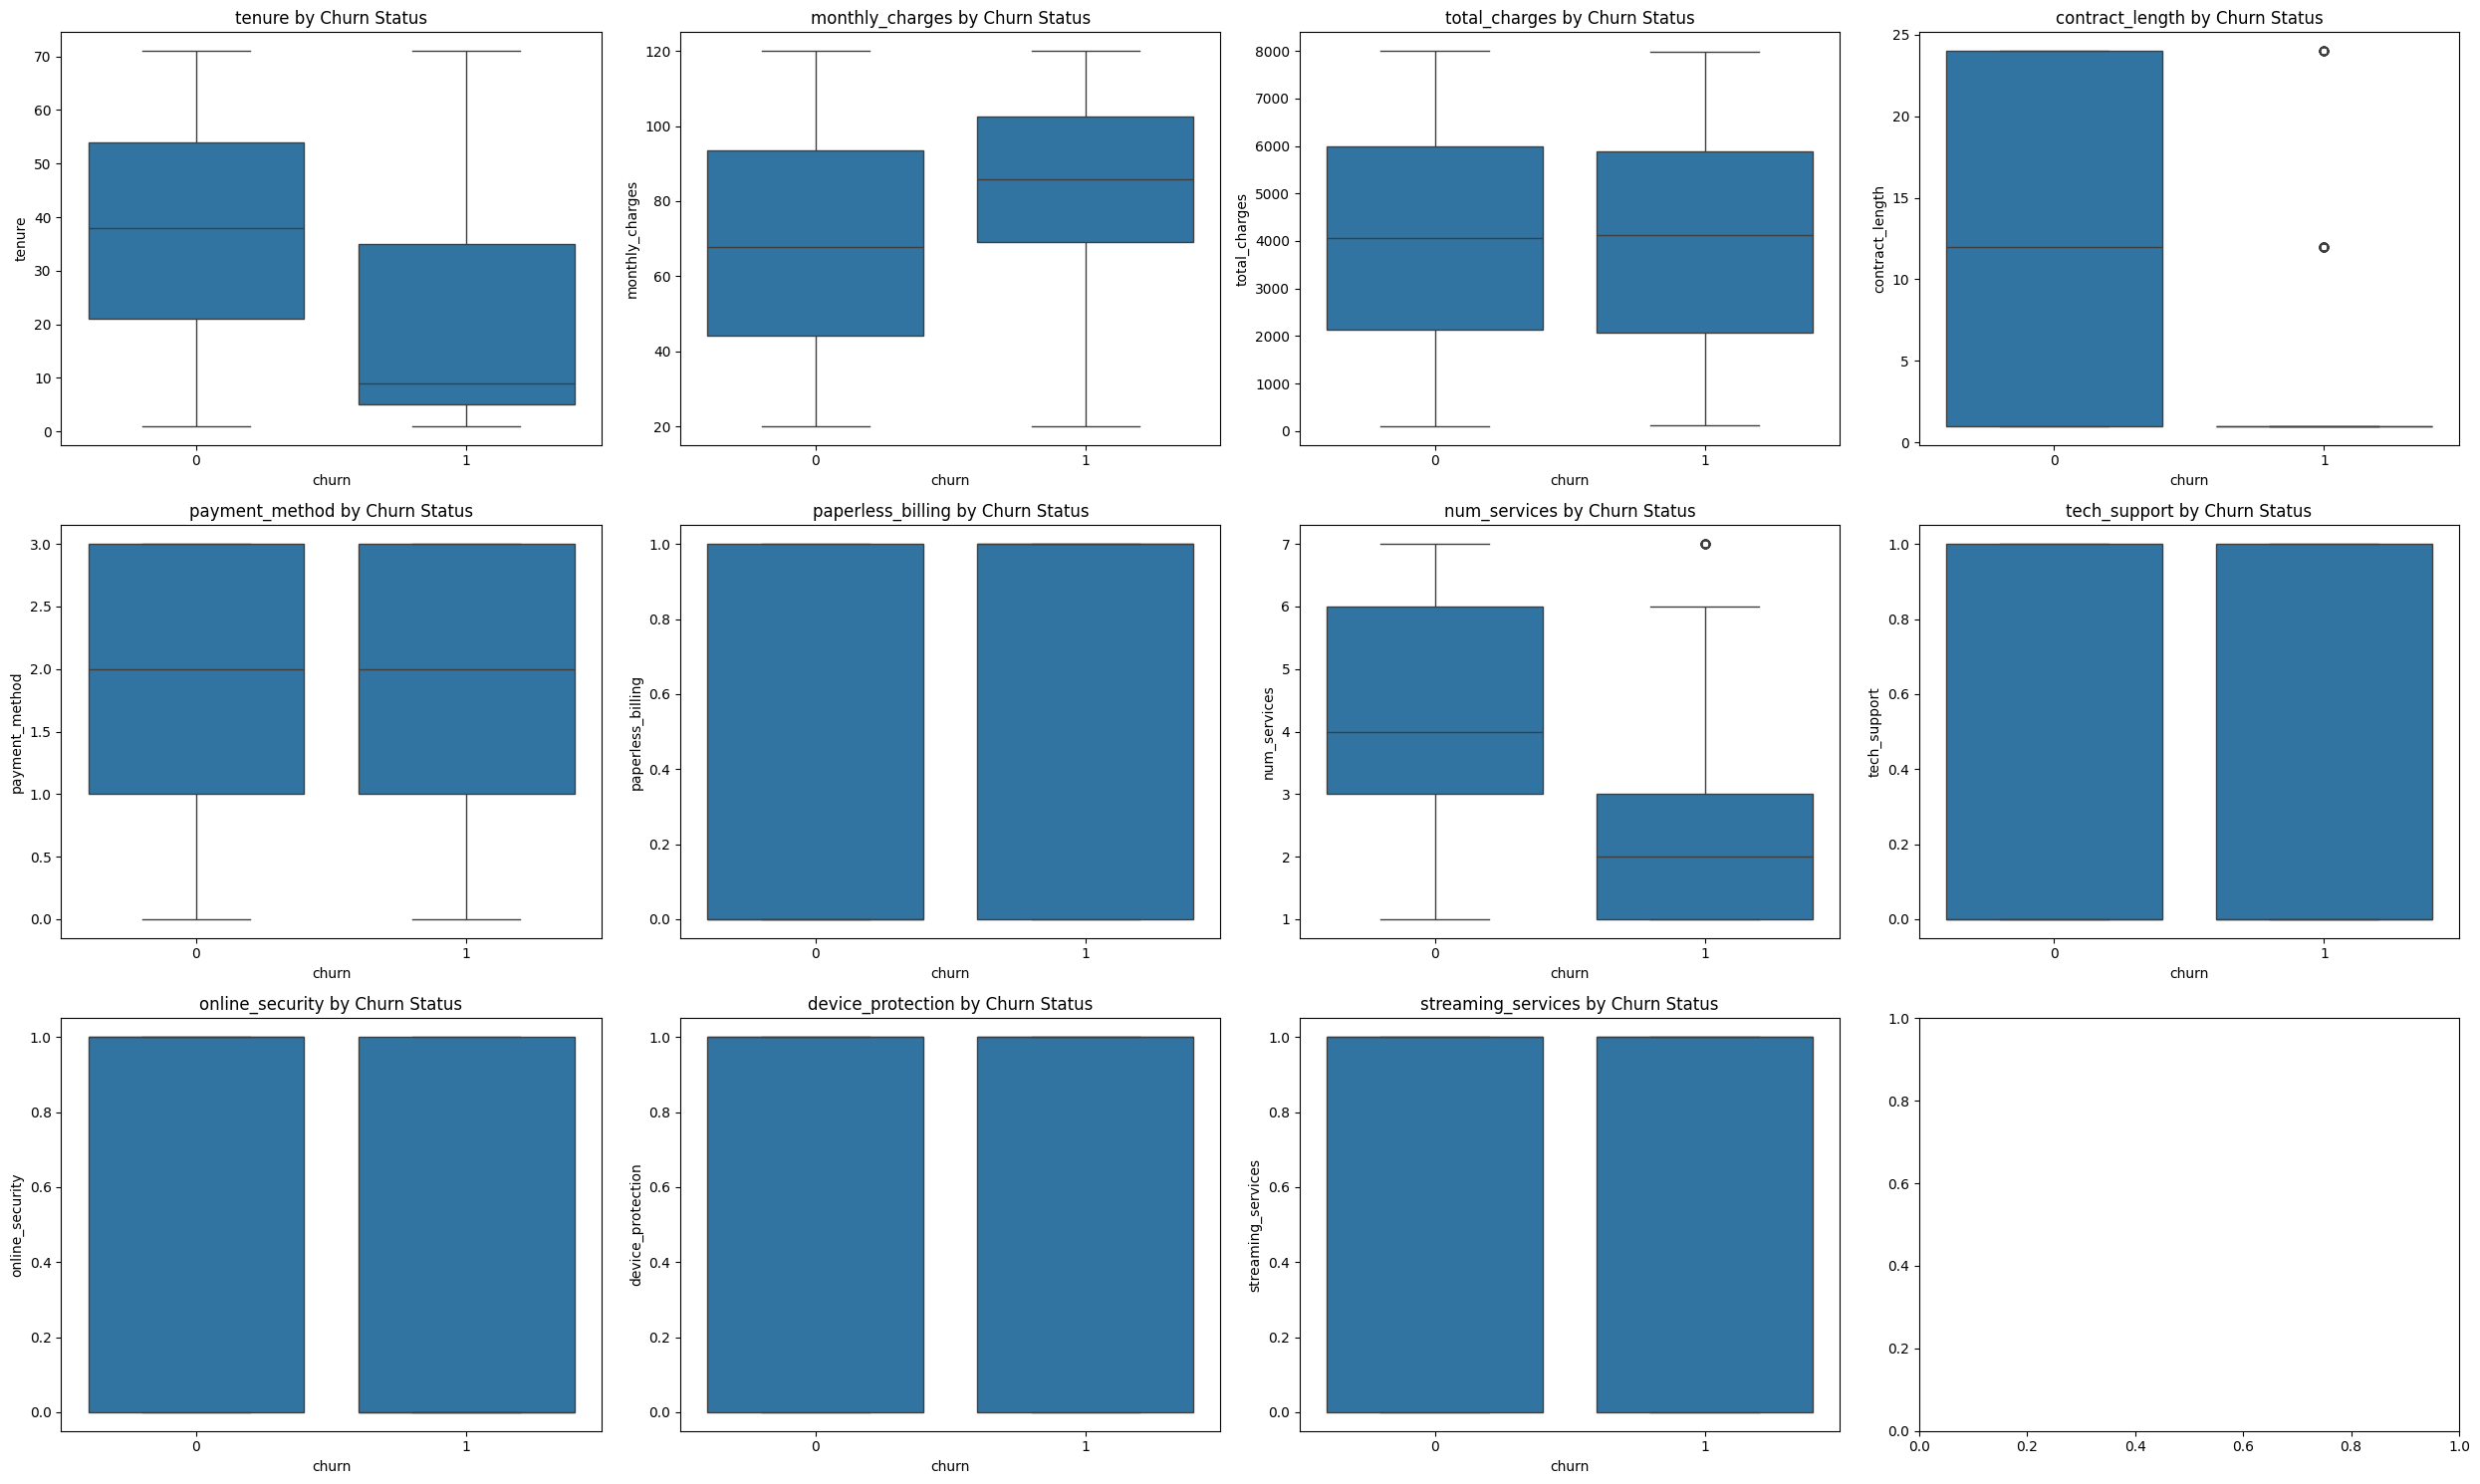

In [56]:
# Create box plots for features vs churn (similar to wine quality analysis)
dims = (3, 4)
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0

for col in data.columns:
    if col == 'churn':
        continue
    sns.boxplot(x=data['churn'], y=data[col], ax=axes[axis_i, axis_j])
    axes[axis_i, axis_j].set_title(f'{col} by Churn Status')
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

plt.tight_layout()
plt.show()

# Check for missing values

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [57]:
# Check for missing values
data.isna().any()

tenure                False
monthly_charges       False
total_charges         False
contract_length       False
payment_method        False
paperless_billing     False
num_services          False
tech_support          False
online_security       False
device_protection     False
streaming_services    False
churn                 False
dtype: bool

In [58]:
from sklearn.model_selection import train_test_split

X = data.drop(["churn"], axis=1)
y = data.churn

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (3000, 11)
Validation set size: (1000, 11)
Test set size: (1000, 11)


In [59]:
# Create wrapper class (same structure as wine lab)
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:, 1]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [60]:
# Train baseline Random Forest model
with mlflow.start_run(run_name='baseline_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions_test = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predictions_test)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Log parameters and metrics
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('auc', auc_score)
    mlflow.log_metric('accuracy', accuracy)
    
    print(f"Baseline AUC: {auc_score:.3f}")
    print(f"Baseline Accuracy: {accuracy:.3f}")
    
    # Wrap and log model
    wrappedModel = SklearnModelWrapper(model)
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    
    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__),
                           "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    
    mlflow.pyfunc.log_model("random_forest_model",
                           python_model=wrappedModel,
                           conda_env=conda_env,
                           signature=signature)

2025/11/03 22:00:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Baseline AUC: 1.000
Baseline Accuracy: 0.996


In [61]:
# Train baseline Random Forest model
with mlflow.start_run(run_name='baseline_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions_test = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predictions_test)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Log parameters and metrics
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('auc', auc_score)
    mlflow.log_metric('accuracy', accuracy)
    
    print(f"Baseline AUC: {auc_score:.3f}")
    print(f"Baseline Accuracy: {accuracy:.3f}")
    
    # Wrap and log model
    wrappedModel = SklearnModelWrapper(model)
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    
    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__),
                           "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    
    mlflow.pyfunc.log_model("random_forest_model",
                           python_model=wrappedModel,
                           conda_env=conda_env,
                           signature=signature)

2025/11/03 22:00:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Baseline AUC: 1.000
Baseline Accuracy: 0.996


In [62]:
# Feature importance analysis
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X_train.columns.tolist(),
    columns=['importance']
)
feature_importances.sort_values('importance', ascending=False)

,importance
tenure,0.345777
contract_length,0.214097
num_services,0.186826
monthly_charges,0.158415
total_charges,0.044547
payment_method,0.017183
paperless_billing,0.007099
device_protection,0.006790
streaming_services,0.006780
tech_support,0.006313


In [63]:
# Get the run ID
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "baseline_random_forest"').iloc[0].run_id
print(f"Run ID: {run_id}")

Run ID: c849c5090d714e2e9c3e9b84d7c019e6


In [64]:
run_id

'c849c5090d714e2e9c3e9b84d7c019e6'

In [65]:
# Register the model
model_name = "customer_churn"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Add a small delay for registration
time.sleep(15)

Registered model 'customer_churn' already exists. Creating a new version of this model...
2025/11/03 22:00:16 WARNING mlflow.tracking._model_registry.fluent: Run with id c849c5090d714e2e9c3e9b84d7c019e6 has no artifacts at artifact path 'random_forest_model', registering model based on models:/m-fa06066d1f684a28a2c1332b93a37802 instead
Created version '3' of model 'customer_churn'.


In [66]:
# Transition to Production
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production",
)

<ModelVersion: aliases=[], creation_timestamp=1762225216169, current_stage='Production', deployment_job_state=None, description=None, last_updated_timestamp=1762225231211, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='accuracy', model_id='m-fa06066d1f684a28a2c1332b93a37802', run_id='c849c5090d714e2e9c3e9b84d7c019e6', step=0, timestamp=1762225213418, value=0.996>,
 <Metric: dataset_digest=None, dataset_name=None, key='auc', model_id='m-fa06066d1f684a28a2c1332b93a37802', run_id='c849c5090d714e2e9c3e9b84d7c019e6', step=0, timestamp=1762225213417, value=0.9999547490836689>], model_id='m-fa06066d1f684a28a2c1332b93a37802', name='customer_churn', params={'n_estimators': '10'}, run_id='c849c5090d714e2e9c3e9b84d7c019e6', run_link=None, source='models:/m-fa06066d1f684a28a2c1332b93a37802', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [37]:
# Load and test the production model
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9999547490836689


In [ ]:
!mlflow ui --port=5001

In [42]:
pip install setuptools

  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [43]:
# Try importing hyperopt
try:
    from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
    from hyperopt.pyll import scope
    USE_HYPEROPT = True
    print("Hyperopt loaded successfully")
except ImportError:
    USE_HYPEROPT = False
    print("Hyperopt not available, will use grid search instead")

Hyperopt loaded successfully


In [44]:
if USE_HYPEROPT:
    # Define search space for Gradient Boosting
    search_space = {
        'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 10)),
        'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    }
    
    def train_model(params):
        """Train Gradient Boosting model with given parameters"""
        with mlflow.start_run(nested=True):
            # Create and train model
            gb_model = GradientBoostingClassifier(
                n_estimators=int(params['n_estimators']),
                max_depth=int(params['max_depth']),
                learning_rate=params['learning_rate'],
                min_samples_split=int(params['min_samples_split']),
                min_samples_leaf=int(params['min_samples_leaf']),
                random_state=123
            )
            
            gb_model.fit(X_train, y_train)
            
            # Evaluate
            val_predictions = gb_model.predict_proba(X_val)[:, 1]
            auc_score = roc_auc_score(y_val, val_predictions)
            
            # Log metrics and parameters
            mlflow.log_params(params)
            mlflow.log_metric('auc', auc_score)
            
            # Log model
            signature = infer_signature(X_train, gb_model.predict_proba(X_train)[:, 1])
            mlflow.sklearn.log_model(gb_model, "model", signature=signature)
            
            return {'status': STATUS_OK, 'loss': -1 * auc_score}
    
    # Run hyperparameter optimization
    trials = Trials()
    
    with mlflow.start_run(run_name='gradient_boosting_models'):
        best_params = fmin(
            fn=train_model,
            space=search_space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials,
        )
    
    print(f"Best parameters: {best_params}")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2025/11/03 21:56:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  5%|▌         | 1/20 [00:01<00:36,  1.93s/trial, best loss: -1.0]

2025/11/03 21:56:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 10%|█         | 2/20 [00:03<00:29,  1.63s/trial, best loss: -1.0]

2025/11/03 21:56:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 15%|█▌        | 3/20 [00:04<00:26,  1.55s/trial, best loss: -1.0]

2025/11/03 21:56:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 20%|██        | 4/20 [00:06<00:23,  1.49s/trial, best loss: -1.0]

2025/11/03 21:56:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 25%|██▌       | 5/20 [00:07<00:21,  1.46s/trial, best loss: -1.0]

2025/11/03 21:56:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 30%|███       | 6/20 [00:09<00:21,  1.55s/trial, best loss: -1.0]

2025/11/03 21:56:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 35%|███▌      | 7/20 [00:10<00:20,  1.56s/trial, best loss: -1.0]

2025/11/03 21:56:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 40%|████      | 8/20 [00:12<00:18,  1.56s/trial, best loss: -1.0]

2025/11/03 21:56:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 45%|████▌     | 9/20 [00:13<00:16,  1.51s/trial, best loss: -1.0]

2025/11/03 21:56:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 50%|█████     | 10/20 [00:15<00:15,  1.51s/trial, best loss: -1.0]

2025/11/03 21:56:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 55%|█████▌    | 11/20 [00:16<00:13,  1.48s/trial, best loss: -1.0]

2025/11/03 21:56:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 60%|██████    | 12/20 [00:18<00:11,  1.47s/trial, best loss: -1.0]

2025/11/03 21:56:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 65%|██████▌   | 13/20 [00:19<00:10,  1.52s/trial, best loss: -1.0]

2025/11/03 21:56:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 70%|███████   | 14/20 [00:21<00:08,  1.48s/trial, best loss: -1.0]

2025/11/03 21:56:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 75%|███████▌  | 15/20 [00:22<00:07,  1.46s/trial, best loss: -1.0]

2025/11/03 21:56:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 80%|████████  | 16/20 [00:24<00:05,  1.45s/trial, best loss: -1.0]

2025/11/03 21:56:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 85%|████████▌ | 17/20 [00:25<00:04,  1.49s/trial, best loss: -1.0]

2025/11/03 21:56:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 90%|█████████ | 18/20 [00:27<00:02,  1.47s/trial, best loss: -1.0]

2025/11/03 21:56:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 95%|█████████▌| 19/20 [00:28<00:01,  1.45s/trial, best loss: -1.0]

2025/11/03 21:56:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



100%|██████████| 20/20 [00:29<00:00,  1.50s/trial, best loss: -1.0]
Best parameters: {'learning_rate': np.float64(0.1544400304280816), 'max_depth': np.float64(6.0), 'min_samples_leaf': np.float64(3.0), 'min_samples_split': np.float64(9.0), 'n_estimators': np.float64(190.0)}


In [45]:
# Find the best run
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 1.0


In [46]:
# Register new model version
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)
time.sleep(10)

Registered model 'customer_churn' already exists. Creating a new version of this model...
2025/11/03 21:56:54 WARNING mlflow.tracking._model_registry.fluent: Run with id 1c557ada6186426c90c4821f6b4b2550 has no artifacts at artifact path 'model', registering model based on models:/m-2ba8a75ddc194c1fa074ea8c79eee78c instead
Created version '2' of model 'customer_churn'.


In [ ]:
# Transition model versions
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage='Archived'
)

client.transition_model_version_stage(
    name=model_name,
    version=new_model_version.version,
    stage='Production'
)

print(f"Model {model_name} version {new_model_version.version} is now in Production")

Model customer_churn version 2 is now in Production


In [48]:
# Test new production model
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f"New Model AUC: {roc_auc_score(y_test, model.predict(X_test))}")

New Model AUC: 1.0


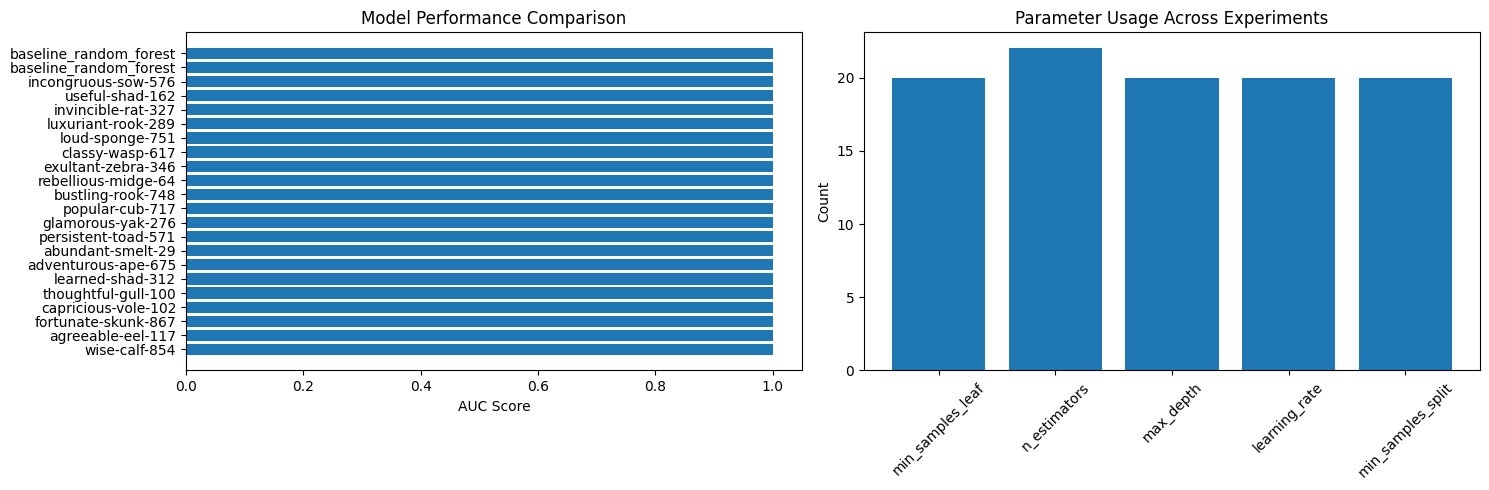

In [49]:
# Create comparison of all models
def create_model_comparison():
    """Compare all trained models"""
    runs = mlflow.search_runs()
    
    # Filter runs with AUC metric
    runs_with_auc = runs[runs['metrics.auc'].notna()]
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # AUC comparison
    axes[0].barh(range(len(runs_with_auc)), runs_with_auc['metrics.auc'])
    axes[0].set_yticks(range(len(runs_with_auc)))
    axes[0].set_yticklabels(runs_with_auc['tags.mlflow.runName'].fillna('unnamed'))
    axes[0].set_xlabel('AUC Score')
    axes[0].set_title('Model Performance Comparison')
    
    # Parameter importance
    param_cols = [col for col in runs.columns if col.startswith('params.')]
    if param_cols:
        param_data = runs_with_auc[param_cols].notna().sum()
        axes[1].bar(range(len(param_data)), param_data.values)
        axes[1].set_xticks(range(len(param_data)))
        axes[1].set_xticklabels([p.replace('params.', '') for p in param_data.index], rotation=45)
        axes[1].set_ylabel('Count')
        axes[1].set_title('Parameter Usage Across Experiments')
    
    plt.tight_layout()
    plt.show()

create_model_comparison()

In [67]:
# Create new data for batch inference
# Ensure data types match the training data
new_customers = pd.DataFrame({
    'tenure': [6, 48, 12],
    'monthly_charges': [80.0, 45.0, 100.0],  # Explicitly set as float
    'total_charges': [480.0, 2160.0, 1200.0],  # Explicitly set as float
    'contract_length': [1, 24, 12],
    'payment_method': [0, 1, 2],
    'paperless_billing': [1, 0, 1],
    'num_services': [2, 5, 7],
    'tech_support': [0, 1, 1],
    'online_security': [0, 1, 1],
    'device_protection': [0, 1, 1],
    'streaming_services': [1, 1, 1],
})

# Ensure correct data types to match training schema
new_customers = new_customers.astype({
    'tenure': 'int64',
    'monthly_charges': 'float64',
    'total_charges': 'float64',
    'contract_length': 'int64',
    'payment_method': 'int64',
    'paperless_billing': 'int64',
    'num_services': 'int64',
    'tech_support': 'int64',
    'online_security': 'int64',
    'device_protection': 'int64',
    'streaming_services': 'int64'
})

# Make predictions
try:
    predictions = model.predict(new_customers)
    new_customers['churn_probability'] = predictions
    
    print("Batch Predictions:")
    print(new_customers[['tenure', 'monthly_charges', 'churn_probability']])
except Exception as e:
    print(f"Prediction error: {e}")
    print("\nData types of new_customers:")
    print(new_customers.dtypes)
    print("\nExpected data types from training set:")
    print(X_train.dtypes)

Batch Predictions:
   tenure  monthly_charges  churn_probability
0       6             80.0                  1
1      48             45.0                  0
2      12            100.0                  0


In [69]:
print("To view the MLflow UI, run in terminal:")
print("mlflow ui --port=5001")
print("\nThen navigate to http://localhost:5001")

To view the MLflow UI, run in terminal:
mlflow ui --port=5001

Then navigate to http://localhost:5001
